# Simulation of LHC instabilities

## Imports

In [1]:
'''
Simulation of beam interaction with coupling impedance and damper
for a single bunch
'''

# using Python 2.7:
from __future__ import division, print_function

In [2]:
range_ = range
range = xrange

In [3]:
import sys

In [4]:
import time

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
np.random.seed(10000042)

In [8]:
import h5py

/home/dagebhar/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
from scipy.constants import e, m_p,c

In [10]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.impedances.wakes import WakeTable, WakeField
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.monitors.monitors import (
    BunchMonitor, ParticleMonitor, SliceMonitor)

PyHEADTAIL v1.12.4




## Defining the paramters of the machine and the beam

In [11]:
n_macroparticles = 100000
n_turns = 10000
n_turns_slicemon = 2048

In [12]:
machine_configuration = 'LHC-injection'
wakefile = ('./wakeforhdtl_PyZbase_Allthemachine_450GeV_B1_LHC_inj_450GeV_B1.dat')

In [13]:
def get_nonlinear_params(chroma, i_oct, p0 = 6.5e12*e/c):
    app_x = 2 * p0 * 27380.10941 * i_oct / 100.
    app_y = 2 * p0 * 28875.03442 * i_oct / 100.
    app_xy = 2 * p0 * -21766.48714 * i_oct / 100.
    Qpp_x = 4889.00298 * i_oct / 100.
    Qpp_y = -2323.147896 * i_oct / 100.
    return {
        'app_x' : app_x,
        'app_y' : app_y,
        'app_xy' : app_xy,
        'Qp_x' : [chroma,],
        'Qp_y' : [chroma,],
    }

In [15]:
intensity = 1.1e11
chroma = -15
i_oct = 0

In [16]:
from LHC import LHC
# assert machine_configuration == 'LHC_6.5TeV_collision_2016'
machine = LHC(n_segments=1,
             machine_configuration=machine_configuration,
             **get_nonlinear_params(chroma=chroma, i_oct=i_oct))

Synchrotron init. From kwargs: app_y = 4.0122274586557525e-10
Synchrotron init. From kwargs: app_x = 3.804505483799897e-10
Synchrotron init. From kwargs: app_xy = -3.024484615716878e-10
Synchrotron init. From kwargs: Qp_x = [10 ...]
Synchrotron init. From kwargs: Qp_y = [10 ...]


In [17]:
epsn_x = 3.e-6
epsn_y = 3.e-6
sigma_z = 1.2e-9 * machine.beta*c/4

bunch = machine.generate_6D_Gaussian_bunch_matched(
n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

print('\n--> Bunch length and emmittance: {:g} m, {:g} eVs'.format(
    bunch.sigma_z(), bunch.epsn_z()))

*** Maximum RMS bunch length 0.11789515101464537m.


/home/dagebhar/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4701e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1288e-03
... distance to target bunch length: -8.3052e-03
... distance to target bunch length: 6.8813e-04
... distance to target bunch length: -1.6258e-05
... distance to target bunch length: 2.5726e-07
... distance to target bunch length: -3.3308e-08
--> Bunch length: 0.08993750859320353
--> Emittance: 0.4786669079717185

--> Bunch length and emmittance: 0.0901048 m, 0.479249 eVs


In [18]:
slicer_for_slicemonitor = UniformBinSlicer(
    50, z_cuts=(-3*sigma_z, 3*sigma_z))
slicer_for_wakefields = UniformBinSlicer(
    100, z_cuts=(-3*sigma_z, 3*sigma_z))
    
wake_table1 = WakeTable(wakefile,
                       ['time', 'dipole_x', 'dipole_y', 'quadrupole_x',
                       'quadrupole_y', 'dipole_xy', 'dipole_yx'])
wake_field = WakeField(slicer_for_wakefields, wake_table1)
machine.one_turn_map.append(wake_field)

dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
dipole_xy Assuming ultrarelativistic wake.
dipole_yx Assuming ultrarelativistic wake.
quadrupole_x Assuming ultrarelativistic wake.
quadrupole_y Assuming ultrarelativistic wake.


## Simulations

without damper (chroma = -15)

In [ ]:
it = 0
outputpath = './'

try:
    bucket = machine.longitudinal_map.get_bucket(bunch)
except AttributeError:
    bucket = machine.rfbucket

simulation_parameters_dict = {
    'gamma' : machine.gamma,
    'intensity' : intensity,
    'Qx' : machine.Q_x,
    'Qy' : machine.Q_y,
    'Qs' : bucket.Q_s,
    'beta_x' : bunch.beta_Twiss_x(),
    'beta_y' : bunch.beta_Twiss_y(),
    'beta_z' : bucket.beta_z,
    'epsn_x' : bunch.epsn_x(),
    'epsn_y' : bunch.epsn_y(),
    'sigma_z' : bunch.sigma_z(),
}
bunchmonitor = BunchMonitor(
    outputpath+'/bunchmonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns, simulation_parameters_dict,
    write_buffer_to_file_array=512,
    buffersize=4096)
slicemonitor = SliceMonitor(
    outputpath+'/slicemonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns_slicemon,
    slicer_for_slicemonitor, simulation_parameters_dict,
    write_buffer_to_file_every=1, buffer_size=n_turns_slicemon)

s_cnt = 0
monitorswitch = False

print ('\n--> Begin tracking...\n')

for i in range(n_turns):

    t0 = time.clock()

    machine.track(bunch)

    ex, ey, ez = bunch.epsn_x(), bunch.epsn_y(), bunch.epsn_z()
    mx, my, mz = bunch.mean_x(), bunch.mean_y(), bunch.mean_z()

    bunchmonitor.dump(bunch)

    if not monitorswitch:
        if mx > 1e-2 or my > 1e-2 or i > n_turns - n_turns_slicemon:
            print ("--> Activate slice monitor")
            monitorswitch = True
    else:
        if s_cnt < n_turns_slicemon:
            slicemonitor.dump(bunch)
            s_cnt += 1

    if not all(np.isfinite(c) for c in [ex, ey, ez, mx, my, mz]):
        print ('*** STOPPING SIMULATION: non-finite bunch stats!')
        break

    if i % 1000 == 0:
        t1 = time.clock()
        print ('Emittances: ({:.3g}, {:.3g}, {:.3g}) '
               '& Centroids: ({:.3g}, {:.3g}, {:.3g})'
               '@ turn {:d}, {:g} ms, {:s}'.format(
                    ex, ey, ez, mx, my, mz, i, (t1-t0)*1e3, time.strftime(
                        "%d/%m/%Y %H:%M:%S", time.localtime()))
        )

print ('\n*** Successfully completed!')

In [14]:
with h5py.File('./bunchmonitor_0000_chroma=-15.h5','r') as bm:
    mean_x = np.array(bm['Bunch']['mean_x'])
    mean_y = np.array(bm['Bunch']['mean_y'])

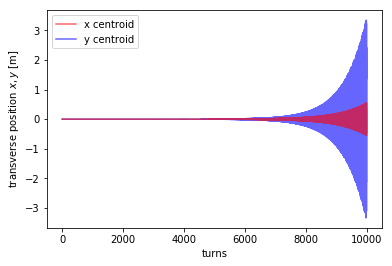

In [37]:
plt.plot(mean_x, label='x centroid', color='red', alpha=0.6)
plt.plot(mean_y, label='y centroid', color='blue', alpha=0.6, zorder=-1)
plt.legend(loc=2)
#plt.xlim(0, 30)
plt.xlabel('turns')
plt.ylabel('transverse position $x, y$ [m]')
#plt.savefig('../instabilities/without_Damper_Chroma-15', dpi=600)
plt.show()

with damper (chroma = -15)

In [19]:
dampingrate = 50
damper = TransverseDamper(dampingrate, dampingrate)
machine.one_turn_map.append(damper)
bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

Dampers active


In [ ]:
it = 1
outputpath = './'

try:
    bucket = machine.longitudinal_map.get_bucket(bunch)
except AttributeError:
    bucket = machine.rfbucket

simulation_parameters_dict = {
    'gamma' : machine.gamma,
    'intensity' : intensity,
    'Qx' : machine.Q_x,
    'Qy' : machine.Q_y,
    'Qs' : bucket.Q_s,
    'beta_x' : bunch.beta_Twiss_x(),
    'beta_y' : bunch.beta_Twiss_y(),
    'beta_z' : bucket.beta_z,
    'epsn_x' : bunch.epsn_x(),
    'epsn_y' : bunch.epsn_y(),
    'sigma_z' : bunch.sigma_z(),
}
bunchmonitor = BunchMonitor(
    outputpath+'/bunchmonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns, simulation_parameters_dict,
    write_buffer_to_file_array=512,
    buffersize=4096)
slicemonitor = SliceMonitor(
    outputpath+'/slicemonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns_slicemon,
    slicer_for_slicemonitor, simulation_parameters_dict,
    write_buffer_to_file_every=1, buffer_size=n_turns_slicemon)

s_cnt = 0
monitorswitch = False

print ('\n--> Begin tracking...\n')

for i in range(n_turns):

    t0 = time.clock()

    machine.track(bunch)

    ex, ey, ez = bunch.epsn_x(), bunch.epsn_y(), bunch.epsn_z()
    mx, my, mz = bunch.mean_x(), bunch.mean_y(), bunch.mean_z()

    bunchmonitor.dump(bunch)

    if not monitorswitch:
        if mx > 1e-2 or my > 1e-2 or i > n_turns - n_turns_slicemon:
            print ("--> Activate slice monitor")
            monitorswitch = True
    else:
        if s_cnt < n_turns_slicemon:
            slicemonitor.dump(bunch)
            s_cnt += 1

    if not all(np.isfinite(c) for c in [ex, ey, ez, mx, my, mz]):
        print ('*** STOPPING SIMULATION: non-finite bunch stats!')
        break

    if i % 1000 == 0:
        t1 = time.clock()
        print ('Emittances: ({:.3g}, {:.3g}, {:.3g}) '
               '& Centroids: ({:.3g}, {:.3g}, {:.3g})'
               '@ turn {:d}, {:g} ms, {:s}'.format(
                    ex, ey, ez, mx, my, mz, i, (t1-t0)*1e3, time.strftime(
                        "%d/%m/%Y %H:%M:%S", time.localtime()))
        )

print ('\n*** Successfully completed!')

In [38]:
with h5py.File('./bunchmonitor_0001_chroma=-15.h5','r') as bm:
    mean_x = np.array(bm['Bunch']['mean_x'])
    mean_y = np.array(bm['Bunch']['mean_y'])

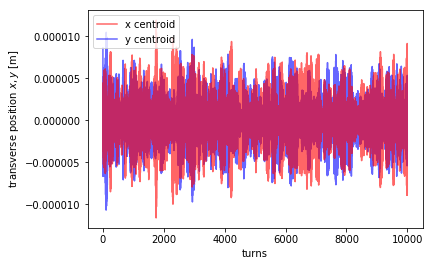

In [39]:
plt.plot(mean_x, label='x centroid', color='red', alpha=0.6)
plt.plot(mean_y, label='y centroid', color='blue', alpha=0.6, zorder=-1)
plt.legend(loc=2)
#plt.xlim(0, 30)
plt.xlabel('turns')
plt.ylabel('transverse position $x, y$ [m]')
#plt.savefig('../instabilities/with_Damper_Chroma-15', dpi=600)
plt.show()

with Damper (Chroma = 10 as it's the setup in CERN machines)

In [ ]:
chroma = 10
machine = LHC(n_segments=1,
             machine_configuration=machine_configuration,
             **get_nonlinear_params(chroma=chroma, i_oct=i_oct))
bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)
machine.one_turn_map.append(wake_field)
machine.one_turn_map.append(damper)

In [ ]:
it = 2
outputpath = './'

try:
    bucket = machine.longitudinal_map.get_bucket(bunch)
except AttributeError:
    bucket = machine.rfbucket

simulation_parameters_dict = {
    'gamma' : machine.gamma,
    'intensity' : intensity,
    'Qx' : machine.Q_x,
    'Qy' : machine.Q_y,
    'Qs' : bucket.Q_s,
    'beta_x' : bunch.beta_Twiss_x(),
    'beta_y' : bunch.beta_Twiss_y(),
    'beta_z' : bucket.beta_z,
    'epsn_x' : bunch.epsn_x(),
    'epsn_y' : bunch.epsn_y(),
    'sigma_z' : bunch.sigma_z(),
}
bunchmonitor = BunchMonitor(
    outputpath+'/bunchmonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns, simulation_parameters_dict,
    write_buffer_to_file_array=512,
    buffersize=4096)
slicemonitor = SliceMonitor(
    outputpath+'/slicemonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns_slicemon,
    slicer_for_slicemonitor, simulation_parameters_dict,
    write_buffer_to_file_every=1, buffer_size=n_turns_slicemon)

s_cnt = 0
monitorswitch = False

print ('\n--> Begin tracking...\n')

for i in range(n_turns):

    t0 = time.clock()

    machine.track(bunch)

    ex, ey, ez = bunch.epsn_x(), bunch.epsn_y(), bunch.epsn_z()
    mx, my, mz = bunch.mean_x(), bunch.mean_y(), bunch.mean_z()

    bunchmonitor.dump(bunch)

    if not monitorswitch:
        if mx > 1e-2 or my > 1e-2 or i > n_turns - n_turns_slicemon:
            print ("--> Activate slice monitor")
            monitorswitch = True
    else:
        if s_cnt < n_turns_slicemon:
            slicemonitor.dump(bunch)
            s_cnt += 1

    if not all(np.isfinite(c) for c in [ex, ey, ez, mx, my, mz]):
        print ('*** STOPPING SIMULATION: non-finite bunch stats!')
        break

    if i % 1000 == 0:
        t1 = time.clock()
        print ('Emittances: ({:.3g}, {:.3g}, {:.3g}) '
               '& Centroids: ({:.3g}, {:.3g}, {:.3g})'
               '@ turn {:d}, {:g} ms, {:s}'.format(
                    ex, ey, ez, mx, my, mz, i, (t1-t0)*1e3, time.strftime(
                        "%d/%m/%Y %H:%M:%S", time.localtime()))
        )

print ('\n*** Successfully completed!')

In [40]:
with h5py.File('./bunchmonitor_0002_chroma=10.h5','r') as bm:
    mean_x = np.array(bm['Bunch']['mean_x'])
    mean_y = np.array(bm['Bunch']['mean_y'])

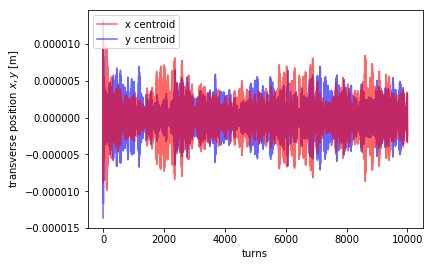

In [41]:
plt.plot(mean_x, label='x centroid', color='red', alpha=0.6)
plt.plot(mean_y, label='y centroid', color='blue', alpha=0.6, zorder=-1)
plt.legend(loc=2)
#plt.xlim(0, 30)
plt.xlabel('turns')
plt.ylabel('transverse position $x, y$ [m]')
#plt.savefig('../instabilities/with_Damper_Chroma10', dpi=600)
plt.show()

with damper but though instabilities caused by oscillations with higher modes after many turns (1'000'000), don"t worry these simulations take hours(Chroma = 10)

In [ ]:
n_turns = 1000000
bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

In [ ]:
it = 3
outputpath = './'

try:
    bucket = machine.longitudinal_map.get_bucket(bunch)
except AttributeError:
    bucket = machine.rfbucket

simulation_parameters_dict = {
    'gamma' : machine.gamma,
    'intensity' : intensity,
    'Qx' : machine.Q_x,
    'Qy' : machine.Q_y,
    'Qs' : bucket.Q_s,
    'beta_x' : bunch.beta_Twiss_x(),
    'beta_y' : bunch.beta_Twiss_y(),
    'beta_z' : bucket.beta_z,
    'epsn_x' : bunch.epsn_x(),
    'epsn_y' : bunch.epsn_y(),
    'sigma_z' : bunch.sigma_z(),
}
bunchmonitor = BunchMonitor(
    outputpath+'/bunchmonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns, simulation_parameters_dict,
    write_buffer_to_file_array=512,
    buffersize=4096)
slicemonitor = SliceMonitor(
    outputpath+'/slicemonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns_slicemon,
    slicer_for_slicemonitor, simulation_parameters_dict,
    write_buffer_to_file_every=1, buffer_size=n_turns_slicemon)

s_cnt = 0
monitorswitch = False

print ('\n--> Begin tracking...\n')

for i in range(n_turns):

    t0 = time.clock()

    machine.track(bunch)

    ex, ey, ez = bunch.epsn_x(), bunch.epsn_y(), bunch.epsn_z()
    mx, my, mz = bunch.mean_x(), bunch.mean_y(), bunch.mean_z()

    bunchmonitor.dump(bunch)

    if not monitorswitch:
        if mx > 1e-2 or my > 1e-2 or i > n_turns - n_turns_slicemon:
            print ("--> Activate slice monitor")
            monitorswitch = True
    else:
        if s_cnt < n_turns_slicemon:
            slicemonitor.dump(bunch)
            s_cnt += 1

    if not all(np.isfinite(c) for c in [ex, ey, ez, mx, my, mz]):
        print ('*** STOPPING SIMULATION: non-finite bunch stats!')
        break

    if i % 1000 == 0:
        t1 = time.clock()
        print ('Emittances: ({:.3g}, {:.3g}, {:.3g}) '
               '& Centroids: ({:.3g}, {:.3g}, {:.3g})'
               '@ turn {:d}, {:g} ms, {:s}'.format(
                    ex, ey, ez, mx, my, mz, i, (t1-t0)*1e3, time.strftime(
                        "%d/%m/%Y %H:%M:%S", time.localtime()))
        )

print ('\n*** Successfully completed!')

In [42]:
with h5py.File('./bunchmonitor_0003_chroma=10.h5','r') as bm:
    mean_x = np.array(bm['Bunch']['mean_x'])
    mean_y = np.array(bm['Bunch']['mean_y'])

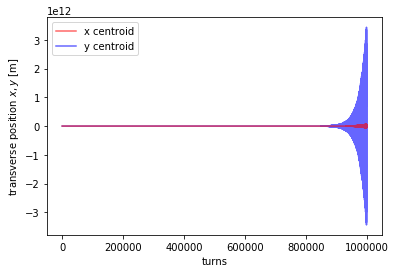

In [43]:
plt.plot(mean_x, label='x centroid', color='red', alpha=0.6)
plt.plot(mean_y, label='y centroid', color='blue', alpha=0.6, zorder=-1)
plt.legend(loc=2)
#plt.xlim(0, 30)
plt.xlabel('turns')
plt.ylabel('transverse position $x, y$ [m]')
#plt.savefig('../instabilities/with_Damper_Chroma10_1000000turns', dpi=600)
plt.show()

with damper, with octupoles (I=200A) (chroma = 10)

In [ ]:
i_oct = 200
machine = LHC(n_segments=1,
             machine_configuration=machine_configuration,
             **get_nonlinear_params(chroma=chroma, i_oct=i_oct))
machine.one_turn_map.append(wake_field)
machine.one_turn_map.append(damper)
bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

In [ ]:
it = 4
outputpath = './'

try:
    bucket = machine.longitudinal_map.get_bucket(bunch)
except AttributeError:
    bucket = machine.rfbucket

simulation_parameters_dict = {
    'gamma' : machine.gamma,
    'intensity' : intensity,
    'Qx' : machine.Q_x,
    'Qy' : machine.Q_y,
    'Qs' : bucket.Q_s,
    'beta_x' : bunch.beta_Twiss_x(),
    'beta_y' : bunch.beta_Twiss_y(),
    'beta_z' : bucket.beta_z,
    'epsn_x' : bunch.epsn_x(),
    'epsn_y' : bunch.epsn_y(),
    'sigma_z' : bunch.sigma_z(),
}
bunchmonitor = BunchMonitor(
    outputpath+'/bunchmonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns, simulation_parameters_dict,
    write_buffer_to_file_array=512,
    buffersize=4096)
slicemonitor = SliceMonitor(
    outputpath+'/slicemonitor_{:04d}_chroma={:g}'.format(it, chroma),
    n_turns_slicemon,
    slicer_for_slicemonitor, simulation_parameters_dict,
    write_buffer_to_file_every=1, buffer_size=n_turns_slicemon)

s_cnt = 0
monitorswitch = False

print ('\n--> Begin tracking...\n')

for i in range(n_turns):

    t0 = time.clock()

    machine.track(bunch)

    ex, ey, ez = bunch.epsn_x(), bunch.epsn_y(), bunch.epsn_z()
    mx, my, mz = bunch.mean_x(), bunch.mean_y(), bunch.mean_z()

    bunchmonitor.dump(bunch)

    if not monitorswitch:
        if mx > 1e-2 or my > 1e-2 or i > n_turns - n_turns_slicemon:
            print ("--> Activate slice monitor")
            monitorswitch = True
    else:
        if s_cnt < n_turns_slicemon:
            slicemonitor.dump(bunch)
            s_cnt += 1

    if not all(np.isfinite(c) for c in [ex, ey, ez, mx, my, mz]):
        print ('*** STOPPING SIMULATION: non-finite bunch stats!')
        break

    if i % 1000 == 0:
        t1 = time.clock()
        print ('Emittances: ({:.3g}, {:.3g}, {:.3g}) '
               '& Centroids: ({:.3g}, {:.3g}, {:.3g})'
               '@ turn {:d}, {:g} ms, {:s}'.format(
                    ex, ey, ez, mx, my, mz, i, (t1-t0)*1e3, time.strftime(
                        "%d/%m/%Y %H:%M:%S", time.localtime()))
        )

print ('\n*** Successfully completed!')

In [24]:
with h5py.File('./bunchmonitor_0004_chroma=10.h5','r') as bm:
    mean_x = np.array(bm['Bunch']['mean_x'])
    mean_y = np.array(bm['Bunch']['mean_y'])

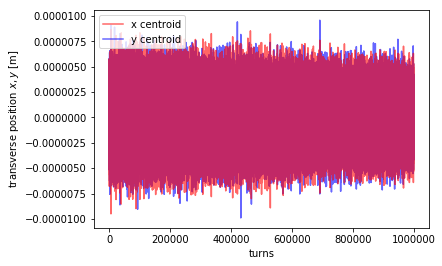

In [27]:
plt.plot(mean_x, label='x centroid', color='red', alpha=0.6)
plt.plot(mean_y, label='y centroid', color='blue', alpha=0.6, zorder=-1)
plt.legend(loc=2)
#plt.xlim(0, 30)
plt.xlabel('turns')
plt.ylabel('transverse position $x, y$ [m]')
#plt.savefig('../instabilities/with_damper_with_octupoles_Chroma10_1000000turns')
plt.show()